In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import math
import optuna
import time
from scipy.integrate import odeint

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EarlyStopping function

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

In [4]:
# Specifying parameters for PFR and other constants taken Siettos et al.'s work (1998)

T0_s = 440 #440 # inlet temperature

k_0 = 3.34 * (np.power(10,8)) # pre-exponential constant

C_p = 25 # heat capacity of reacting liquid

rho_L = 47 # density of reacting liquid

T_s = 423 # steady-state reactor temperature                

u = 2 # volumetric flow rate  (F/A) Superficial velocity

E_by_R = 8600 # activation energy (E/R)

delH_term = -44000 # enthalpy of reaction

U = 25 #Overall heat transfer coeffecient

CA0_s = 1.6 #  steady-state inlet concentration of A

CA_s = 0.11 # steady-state reactor concentration of A         

Tc_s = 293 # steady state cooling temperature

At = 0.01 # Area for heating rate equation

A = 0.002  # Area

t_final = 0.1 #0.01 # end time for numerical simulation

t_step = 0.02 #1e-3 # integration time step h_c

P = np.array([[1060, 22], [22, 0.52]]) # a positive definite matrix             

length = 1 # total length of reactor

N = 10     # number of points to discretize the reactor 

# Euler Method

In [5]:
def PFR_simulation_Euler(u, delH_term, k_0, C_p, rho_L, E_by_R, Tc, U, At, A, t_final, t_step, init_C, init_T):

    # Method of lines approximates the spatial derivative using finite difference method which reults in a set of coupled ODE
    
    def method_of_lines_C(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(C) / np.diff(z) - k_0 * np.exp(-E_by_R/T[1:]) * C[1:]    # for first order
        return np.concatenate([[0], D]) #C0 is constant at entrance


    def method_of_lines_T(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(T) / np.diff(z) + (-delH_term/(rho_L*C_p)) * k_0 * np.exp(-E_by_R/T[1:])* C[1:] + (U/(rho_L*C_p*A)) * At * (Tc - T[1:]) # for first order
        return np.concatenate([[0], D]) #T0 is constant at entrance

    N = 10     # number of points to discretize the reactor length
    z = np.linspace(0, length, N) # discretized length elements
    
    #initializing arrays
    init_C_A_2_1 = np.zeros(N)
    init_T_2_1 = np.zeros(N)  
    
    init_C_A_2_2 = np.zeros(N)
    init_T_2_2 = np.zeros(N)   
    
    init_C_A_3 = np.zeros(N)
    init_T_3 = np.zeros(N)    
    
    C_A_3 = np.zeros(N)
    T_3 = np.zeros(N)    
    
    
    dCAdt1 = method_of_lines_C(init_C, init_T)
    dTdt1 = method_of_lines_T(init_C, init_T)
    
    for i in range(len(init_C)):        
        init_C_A_2_1[i] = init_C[i] + dCAdt1[i] * t_step / 2
        init_T_2_1[i] = init_T[i] + dTdt1[i] * t_step / 2
        
    dCAdt2_1 = method_of_lines_C(init_C_A_2_1, init_T_2_1)
    dTdt2_1 = method_of_lines_T(init_C_A_2_1, init_T_2_1)        
        
    for i in range(len(init_C)):
        init_C_A_2_2[i] = init_C[i] + dCAdt2_1[i] * t_step / 2
        init_T_2_2[i] = init_T[i] + dTdt2_1[i] * t_step / 2
        
    dCAdt2_2 = method_of_lines_C(init_C_A_2_2, init_T_2_2)
    dTdt2_2 = method_of_lines_T(init_C_A_2_2, init_T_2_2)           
        
    for i in range(len(init_C)):       
        init_C_A_3[i] = init_C[i] + dCAdt2_2[i] * t_step / 2
        init_T_3[i] = init_T[i] + dTdt2_2[i] * t_step / 2
        
    dCAdt3 = method_of_lines_C(init_C_A_3, init_T_3)
    dTdt3 = method_of_lines_T(init_C_A_3, init_T_3)           
        
    dCAdt2 = np.add(dCAdt2_1,dCAdt2_2)
    dCAdt2 = np.divide(dCAdt2,2)
      
    dTdt2 = np.add(dTdt2_1,dTdt2_2)
    dTdt2 = np.divide(dTdt2,2)        

    for i in range(len(init_C)):      
        C_A_3[i] = init_C[i] + t_step / 6 * (dCAdt1[i] + 4*dCAdt2[i] + dCAdt3[i])     
        T_3[i] = init_T[i] + t_step / 6 * (dTdt1[i] + 4*dTdt2[i] + dTdt3[i])    

    return C_A_3 , T_3  

# Data generation (PI-RNN) collocation points

In [6]:
# generating inputs and initial states for PFR

u2_physics_list = np.linspace(100, 300, 20) # u2 is the cooling temp
T_physics_initial = np.linspace(300, 500, 20)  # inlet temperature
CA_physics_initial = np.linspace(0.5, 3, 20)  # inlet concentration

In [7]:
# Grouping the initial state vectors

T_physics_start = list()
CA_physics_start = list()

for T in T_physics_initial:
    for CA in CA_physics_initial:
        CA_physics_start.append(CA)
        T_physics_start.append(T)
            
print("number of initial conditions: {}".format(len(CA_physics_start)))

# convert to np.arrays
CA_physics_start = np.array([CA_physics_start])
T_physics_start = np.array([T_physics_start])
x_physics_original = np.concatenate((CA_physics_start.T, T_physics_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_physics_original is {}".format(x_physics_original.shape))

number of initial conditions: 400
shape of x_physics_original is (400, 2)


In [8]:
# get X and y data for physics-informed model

CA_physics_output = list()
T_physics_output = list()
CA_physics_input = list()
T_physics_input = list()
Tc_physics_input = list()


for num_id, u2 in enumerate(u2_physics_list):
    print(f"{num_id + 1} out of {u2_physics_list.shape[0]}")    #just to count and keep track
    Tc = u2 + Tc_s
        
    for C_A_initial, T_initial in x_physics_original:
        Tc_physics_input.append(u2)
        CA_physics_input.append(C_A_initial)
        T_physics_input.append(T_initial)
            
        N = 10     # number of points to discretize the reactor length
        z = np.linspace(0, length, N) # discretized length elements      
        init_C = np.zeros(N)    # Concentration in reactor at t = 0
        init_C[0] = C_A_initial          # concentration at entrance   
        init_T = np.zeros(N)    # T in reactor at t = 0
        for i in range(len(init_T)):
            if i == 0:
                init_T[i] = T_initial 
            else:
                init_T[i] = 293   # at room temperature and scaled with Steady State value
            
        C_A_list = [init_C] 
        T_list = [init_T]            
                                
        for _ in range(int(t_final / t_step)):
            
            CA_next, T_next = PFR_simulation_Euler(u, delH_term, k_0, C_p, rho_L, E_by_R, Tc, U, At, A, t_final, t_step, init_C, init_T)
            C_A_list.append(CA_next)
            T_list.append(T_next)
            init_C = CA_next
            init_T = T_next
             
        CA_physics_output.append(C_A_list)
        T_physics_output.append(T_list)

1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20
20 out of 20


# Collating Input and Output for RNN

In [9]:
# collate input for RNN for physics loss

Tc_physics_input = np.array(Tc_physics_input)
Tc_physics_input = Tc_physics_input.reshape(-1,1,1)


CA_physics_input = np.array(CA_physics_input)
CA_physics_input = CA_physics_input.reshape(-1,1,1)


T_physics_input = np.array(T_physics_input)
T_physics_input = T_physics_input.reshape(-1,1,1)


RNN_physics_input_temp = np.concatenate((Tc_physics_input, CA_physics_input, T_physics_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step
"""

RNN_physics_input_temp = RNN_physics_input_temp.repeat(6, axis=1)
print("RNN_physics_input_temp shape is {}".format(RNN_physics_input_temp.shape))

RNN_physics_input_temp shape is (8000, 6, 3)


In [10]:
############################## collate output for RNN ####################################################

CA_physics_output = np.array(CA_physics_output)
CA_physics_output = CA_physics_output.reshape(-1, 6, 10)

T_physics_output = np.array(T_physics_output)
T_physics_output = T_physics_output.reshape(-1, 6, 10)

RNN_physics_output = np.concatenate((CA_physics_output, T_physics_output), axis=2)
print("RNN_physics_output shape is {}".format(RNN_physics_output.shape))  # output shape: number of samples x timestep x variables


RNN_physics_output shape is (8000, 6, 20)


In [11]:
############################### Split into Training, Test, and Validation Data ################################

X_train, X_test, y_train, y_test = train_test_split(RNN_physics_input_temp, RNN_physics_output, test_size=0.2, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123) # 0.25 x 0.8 = 0.2

print(f"X_train shape is {X_train.shape}, X_val shape is {X_val.shape}, X_test shape is {X_test.shape}")
print(f"y_train shape is {y_train.shape}, y_val shape is {y_val.shape}, y_test shape is {y_test.shape}")

X_train shape is (4800, 6, 3), X_val shape is (1600, 6, 3), X_test shape is (1600, 6, 3)
y_train shape is (4800, 6, 20), y_val shape is (1600, 6, 20), y_test shape is (1600, 6, 20)


In [12]:
# Extract mean and standard deviation dor Standardization

mean_Tc = np.mean(X_train[:, 0, 0].reshape(-1))
std_Tc = np.std(X_train[:, 0, 0].reshape(-1))

# Initializing arrays
mean_CA_input=np.zeros(N)
std_CA_input=np.zeros(N)

mean_T_input=np.zeros(N)
std_T_input=np.zeros(N)

# Computing mean and standard deviation
mean_CA_input = np.mean(X_train[:, 0, -2].reshape(-1))
std_CA_input = np.std(X_train[:, 0, -2].reshape(-1))

mean_T_input = np.mean(X_train[:, 0, -1].reshape(-1))
std_T_input = np.std(X_train[:, 0, -1].reshape(-1))


# Extracting mean and standard deviation for concentration and temperature across all samples and time step

mean_Cy = np.mean(y_train[:, :, :10])
std_Cy = np.std(y_train[:, :, :10])

mean_Ty = np.mean(y_train[:, :, 10:])
std_Ty = np.std(y_train[:, :, 10:])

# Initializing arrays
mean_Cy_rep = mean_Cy.repeat(N, axis=0)
std_Cy_rep = std_Cy.repeat(N, axis=0)
mean_Ty_rep = mean_Ty.repeat(N, axis=0)
std_Ty_rep = std_Ty.repeat(N, axis=0)
    
# Computing mean and standard deviation
mean_y = np.concatenate((mean_Cy_rep.reshape(-1), mean_Ty_rep.reshape(-1)))
std_y = np.concatenate((std_Cy_rep.reshape(-1), std_Ty_rep.reshape(-1))) 

mean_y = torch.from_numpy(mean_y).float()
std_y = torch.from_numpy(std_y).float()

In [13]:
# scaling the input dataset (x_physics)
X_physics_train = (X_train - [mean_Tc, mean_CA_input, mean_T_input]) / [std_Tc, std_CA_input, std_T_input]
X_physics_train = torch.from_numpy(X_physics_train).float()

X_physics_val = (X_val - [mean_Tc, mean_CA_input, mean_T_input]) / [std_Tc, std_CA_input, std_T_input]
X_physics_val = torch.from_numpy(X_physics_val).float()

X_physics_test = (X_test - [mean_Tc, mean_CA_input, mean_T_input]) / [std_Tc, std_CA_input, std_T_input]
X_physics_test = torch.from_numpy(X_physics_test).float()

# scaling the output dataset

y_train_p = (y_train - mean_y.detach().numpy()) / (std_y.detach().numpy())
y_train_p = torch.from_numpy(y_train_p).float()

y_test_p = (y_test - mean_y.detach().numpy()) / (std_y.detach().numpy())
y_test_p = torch.from_numpy(y_test_p).float()

y_val_p = (y_val - mean_y.detach().numpy()) / (std_y.detach().numpy())
y_val_p = torch.from_numpy(y_val_p).float()

print(f'X_physics shape is: {X_physics_train.shape}')

X_physics shape is: torch.Size([4800, 6, 3])


# Preparing dataset for PyTorch

In [14]:
dataset_physics_train = TensorDataset(X_physics_train, y_train_p)
dataloader_physics_train = DataLoader(dataset_physics_train, batch_size=10800, shuffle=True)

dataset_physics_val = TensorDataset(X_physics_val, y_val_p)
dataloader_physics_val = DataLoader(dataset_physics_val, batch_size=10800, shuffle=True)

dataset_physics_test = TensorDataset(X_physics_test, y_test_p)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

# Defining RNN

In [15]:
class RNN(nn.Module):
    "Defines a RNN network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS
        
        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN[0], 
                                batch_first=True)
            
            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i], 
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )
            
            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)
            
            self.list_flag = True
            
        else:
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)
            
            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
            
            self.list_flag = False            
          
        
    def forward(self, x):
        x, _ = self.rnn(x)
        
        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)
                
        x = self.output_layer(x)
        return x

# Physics-informed RNN

In [17]:
def train_model(model, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        
        model.train() # prep model for training
        for batch, (x_batch, y_train_batch) in enumerate(dataloader_physics_train, 1):
            # clear the gradients of all optimized variables
            x_batch = x_batch[0].to(device)
            y_train_batch = y_train_batch[0].to(device)
            optimizer.zero_grad()
            
            NN_output = model_PINN(x_batch)            
            
            # Data-driven loss
            loss1 = torch.mean((NN_output[:, :10] -  y_train_batch[:, :10])**2)  # use mean squared error
            loss1_1 = torch.mean((NN_output[:, 10:] - y_train_batch[:, 10:])**2)  # use mean squared error
            
            # for inital condition
            loss2 = torch.mean((NN_output[0, :] - y_train_batch[0, :])**2)
            
            # collocation point loss
            loss21 = torch.mean((NN_output[0, [0,10]] - x_batch[0, 1:])**2)

            
            # compute the "physics loss"
            Tc = x_batch[:, 0] * std_Tc + mean_Tc + Tc_s
            

            # Reversing standardization
            NN_output = NN_output * std_y.to(device) + mean_y.to(device)
            
            
            dCA_first = (NN_output[ 1:2, :10] - NN_output[0:1, :10]) / (t_step)
            dT_first = (NN_output[ 1:2, 10:] - NN_output[ 0:1, 10:]) / (t_step)
            
            
            dCA_center = (NN_output[ 2:, :10] - NN_output[ :-2, :10]) / (2*t_step)
            dT_center = (NN_output[ 2:, 10:] - NN_output[:-2, 10:]) / (2*t_step)
            
            
            dCA_last = (NN_output[ -1:, :10] - NN_output[ -2:-1, :10]) / (t_step)
            dT_last = (NN_output[ -1:, 10:] - NN_output[ -2:-1, 10:]) / (t_step)


            dCA = torch.cat((dCA_first, dCA_center, dCA_last), 0)
            dT = torch.cat((dT_first, dT_center, dT_last), 0)
                      
            # taking in first point
            loss3_1 = dCA[:,1:] - (-u * torch.from_numpy(np.diff(NN_output[ :, :10].detach().numpy(force=True)) / np.diff(z)) - k_0 * torch.exp(-E_by_R/NN_output[ :, 11:]) * NN_output[:, 1:10])            
            loss3_2 = dCA[:,0] - 0
            loss3_2 = torch.reshape(loss3_2,(6,1))
            loss3 = torch.cat((loss3_2, loss3_1),1)
            loss3 = torch.mean(loss3**2)            
            
            
            #taking in first point
            loss4_1 = dT[:,1:] - (-u * torch.from_numpy(np.diff(NN_output[ :, 10:].detach().numpy(force=True)) / np.diff(z)) + (-delH_term/(rho_L*C_p)) * k_0 * torch.exp(-E_by_R/NN_output[ :, 11:]) * NN_output[ :, 1:10] - (U/(rho_L*C_p*A)) * At * (NN_output[:, 11:]-Tc[0]))            
            loss4_2 = dT[:,0] - 0
            loss4_2 = torch.reshape(loss4_2,(6,1))
            loss4 = torch.cat((loss4_2, loss4_1),1)           
            loss4 = torch.mean(loss4**2)
            
            
            # Partial PIRNN (Assuming we only have Temperature data available)
            loss =  10e3*(loss1_1) + loss21 + 10e3*loss2 + 10e0*loss3 # add all loss terms together

            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for (val_batch, y_val_batch) in dataloader_physics_val:
            
            # forward pass: compute predicted outputs by passing inputs to the model
            val_batch = val_batch[0].to(device)
            y_val_batch = y_val_batch[0].to(device)
            NN_output = model(val_batch)
            
            # Data-driven loss
            loss1 = torch.mean((NN_output[:, :10] -  y_val_batch[:, :10])**2)  # use mean squared error
            loss1_1 = torch.mean((NN_output[:, 10:] - y_val_batch[:, 10:])**2)  # use mean squared error
            
            
            # for inital condition
            loss2 = torch.mean((NN_output[0, :] - y_val_batch[0, :])**2)          
            
            # collocation point loss
            loss21 = torch.mean((NN_output[0, [0,10]] - val_batch[0, 1:])**2)
            
            # compute the "physics loss"
            Tc = val_batch[:, 0] * std_Tc + mean_Tc + Tc_s
            
            # Reversing Standardization
            NN_output = NN_output * std_y.to(device) + mean_y.to(device)
            
            
            dCA_first = (NN_output[ 1:2, :10] - NN_output[0:1, :10]) / (t_step)
            dT_first = (NN_output[ 1:2, 10:] - NN_output[ 0:1, 10:]) / (t_step)
            
            
            dCA_center = (NN_output[ 2:, :10] - NN_output[ :-2, :10]) / (2*t_step)
            dT_center = (NN_output[ 2:, 10:] - NN_output[:-2, 10:]) / (2*t_step)
            
            
            dCA_last = (NN_output[ -1:, :10] - NN_output[ -2:-1, :10]) / (t_step)
            dT_last = (NN_output[ -1:, 10:] - NN_output[ -2:-1, 10:]) / (t_step)


            dCA = torch.cat((dCA_first, dCA_center, dCA_last), 0)
            dT = torch.cat((dT_first, dT_center, dT_last), 0)
                       
            #taking in first point
            loss3_1 = dCA[:,1:] - (-u * torch.from_numpy(np.diff(NN_output[ :, :10].detach().numpy(force=True)) / np.diff(z)) - k_0 * torch.exp(-E_by_R/NN_output[ :, 11:]) * NN_output[:, 1:10])            
            loss3_2 = dCA[:,0] - 0
            loss3_2 = torch.reshape(loss3_2,(6,1))
            loss3 = torch.cat((loss3_2, loss3_1),1)
            loss3 = torch.mean(loss3_1**2)            
             
            #taking in first point
            loss4_1 = dT[:,1:] - (-u * torch.from_numpy(np.diff(NN_output[ :, 10:].detach().numpy(force=True)) / np.diff(z)) + (-delH_term/(rho_L*C_p)) * k_0 * torch.exp(-E_by_R/NN_output[ :, 11:]) * NN_output[ :, 1:10] - (U/(rho_L*C_p*A)) * At * (NN_output[:, 11:]-Tc[0]))            
            loss4_2 = dT[:,0] - 0
            loss4_2 = torch.reshape(loss4_2,(6,1))
            loss4 = torch.cat((loss4_2, loss4_1),1)           
            loss4 = torch.mean(loss4_1**2)  
            
            # Partial PIRNN (Assuming we only have Temperature data available)
            loss =  10e3*(loss1_1) + loss21 + 10e3*loss2 + 10e0*loss3 # add all loss terms together       
           
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [18]:
start_time = time.time()

# define the structure of the Recurrent Neural Network model
model_PINN = RNN(3, 20, 256, 3)
model_PINN.to(device)

print(model_PINN)

optimizer = torch.optim.Adam(model_PINN.parameters(),lr=1e-3) #1e-3

n_epochs = 1500 # can be changed

# early stopping patience; how long to wait after last time validation loss improved.
patience = 600

model, train_loss, valid_loss = train_model(model_PINN, patience, n_epochs)

print("--- %s seconds ---" % (time.time() - start_time))

RNN(
  (rnn): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=256, out_features=20, bias=True)
)
tensor(0.8315, grad_fn=<MeanBackward0>)
[   1/1500] train_loss: 12347.53003 valid_loss: 6268.06990
Validation loss decreased (inf --> 6268.069895).  Saving model ...
tensor(0.4435, grad_fn=<MeanBackward0>)
[   2/1500] train_loss: 17383.30709 valid_loss: 5737.37505
Validation loss decreased (6268.069895 --> 5737.375046).  Saving model ...
tensor(1.4693, grad_fn=<MeanBackward0>)
[   3/1500] train_loss: 40376.56317 valid_loss: 10085.53915
EarlyStopping counter: 1 out of 600
tensor(1.1064, grad_fn=<MeanBackward0>)
[   4/1500] train_loss: 9728.23574 valid_loss: 39555.27333
EarlyStopping counter: 2 out of 600
tensor(0.2865, grad_fn=<MeanBackward0>)
[   5/1500] train_loss: 15536.79610 valid_loss: 35906.01249
EarlyStopping counter: 3 out of 600
tensor(0.2293, grad_fn=<MeanBackward0>)
[   6/1500] train_loss: 11385.56421 valid_loss: 34700.99886
EarlyStop

# Saving model

In [19]:
y_test_error = list()
total_batch_num = y_test.shape[0]

for batch_num, (x_batch_test, y_test_batch) in enumerate(dataloader_physics_test, 1):
    print(f"{batch_num} out of {total_batch_num}")
    model.eval()
    model.to("cpu")
    
    # forward pass: compute predicted outputs by passing inputs to the model
    x_batch_test = x_batch_test[0]
    y_test_batch = y_test_batch[0].to(device)
    NN_output = model(x_batch_test)

    
    # Data-driven loss
    loss1 = torch.mean((NN_output[:, :10] -  y_test_batch[:, :10])**2)  # use mean squared error
    loss1_1 = torch.mean((NN_output[:, 10:] - y_test_batch[:, 10:])**2)  # use mean squared error
        
    
    # for inital condition
    loss2 = torch.mean((NN_output[0, :] - y_test_batch[0, :])**2)    
    
    # collocation point loss
    loss21 = torch.mean((NN_output[0, [0,10]] - x_batch_test[0, 1:])**2)
    
    
    # compute the "physics loss"
    Tc = x_batch_test[:, 0] * std_Tc + mean_Tc + Tc_s
            

    # Reversing standardization
    NN_output = NN_output * std_y.to(device) + mean_y.to(device)
            
            
    dCA_first = (NN_output[ 1:2, :10] - NN_output[0:1, :10]) / (t_step)
    dT_first = (NN_output[ 1:2, 10:] - NN_output[ 0:1, 10:]) / (t_step)
            
            
    dCA_center = (NN_output[ 2:, :10] - NN_output[ :-2, :10]) / (2*t_step)
    dT_center = (NN_output[ 2:, 10:] - NN_output[:-2, 10:]) / (2*t_step)
            
            
    dCA_last = (NN_output[ -1:, :10] - NN_output[ -2:-1, :10]) / (t_step)
    dT_last = (NN_output[ -1:, 10:] - NN_output[ -2:-1, 10:]) / (t_step)


    dCA = torch.cat((dCA_first, dCA_center, dCA_last), 0)
    dT = torch.cat((dT_first, dT_center, dT_last), 0)
                        
    #taking in first point
    loss3_1 = dCA[:,1:] - (-u * torch.from_numpy(np.diff(NN_output[ :, :10].detach().numpy(force=True)) / np.diff(z)) - k_0 * torch.exp(-E_by_R/NN_output[ :, 11:]) * NN_output[:, 1:10])            
    loss3_2 = dCA[:,0] - 0
    loss3_2 = torch.reshape(loss3_2,(6,1))
    loss3 = torch.cat((loss3_2, loss3_1),1)
    loss3 = torch.mean(loss3_1**2)            
            
    #taking in first point
    loss4_1 = dT[:,1:] - (-u * torch.from_numpy(np.diff(NN_output[ :, 10:].detach().numpy(force=True)) / np.diff(z)) + (-delH_term/(rho_L*C_p)) * k_0 * torch.exp(-E_by_R/NN_output[ :, 11:]) * NN_output[ :, 1:10] - (U/(rho_L*C_p*A)) * At * (NN_output[:, 11:]-Tc[0]))            
    loss4_2 = dT[:,0] - 0
    loss4_2 = torch.reshape(loss4_2,(6,1))
    loss4 = torch.cat((loss4_2, loss4_1),1)           
    loss4 = torch.mean(loss4_1**2)
    
    
    # Partial PIRNN (Assuming we only have Temperature data available)
    loss = 10e3*(loss1_1) + loss21 + 10e3*loss2 + 10e0*loss3 # add all loss terms together 

 
    # record validation loss
    y_test_error.append(loss.item())

1 out of 1600
2 out of 1600
3 out of 1600
4 out of 1600
5 out of 1600
6 out of 1600
7 out of 1600
8 out of 1600
9 out of 1600
10 out of 1600
11 out of 1600
12 out of 1600
13 out of 1600
14 out of 1600
15 out of 1600
16 out of 1600
17 out of 1600
18 out of 1600
19 out of 1600
20 out of 1600
21 out of 1600
22 out of 1600
23 out of 1600
24 out of 1600
25 out of 1600
26 out of 1600
27 out of 1600
28 out of 1600
29 out of 1600
30 out of 1600
31 out of 1600
32 out of 1600
33 out of 1600
34 out of 1600
35 out of 1600
36 out of 1600
37 out of 1600
38 out of 1600
39 out of 1600
40 out of 1600
41 out of 1600
42 out of 1600
43 out of 1600
44 out of 1600
45 out of 1600
46 out of 1600
47 out of 1600
48 out of 1600
49 out of 1600
50 out of 1600
51 out of 1600
52 out of 1600
53 out of 1600
54 out of 1600
55 out of 1600
56 out of 1600
57 out of 1600
58 out of 1600
59 out of 1600
60 out of 1600
61 out of 1600
62 out of 1600
63 out of 1600
64 out of 1600
65 out of 1600
66 out of 1600
67 out of 1600
68 o

In [20]:
# Evaluation of the Test dataset

print(f"mean error is {np.mean(y_test_error)}, std is {np.std(y_test_error)}")

mean error is 75.12906284766929, std is 58.51800833658045


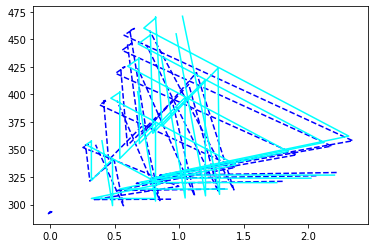

In [21]:
# Data visualization between Test and Predicted data for the time-series data of a few sample datapoints

y_pred1 = model(X_physics_test)

y_pred1 = y_pred1 * std_y.to('cpu') + mean_y.to('cpu')

y_pred1 = y_pred1.detach().numpy()

plt.plot(y_pred1[0:50:5, :, 1], y_pred1[0:50:5, :, 11], color='blue', ls='--')
plt.plot(y_test[0:50:5, :, 1], y_test[0:50:5, :, 11], color='cyan')

In [22]:
# Measures the similarity between the above predicted and test data profile

import similaritymeasures

conpred = np.concatenate((y_pred1[0:50:5, :, 1], y_pred1[0:50:5, :, 11]),1)
conpred = conpred.reshape(10,6,2)

contest = np.concatenate((y_test[0:50:5, :, 1], y_test[0:50:5, :, 11]),1)
contest = contest.reshape(10,6,2)

mseA = similaritymeasures.mse(contest, conpred)
print(mseA)

12.324767643593388


In [23]:
model_PINN.eval()
model_PINN.to('cpu')
y_predict_test = model_PINN(X_physics_test[:500, :, :]).detach().numpy()
y_predict_test = y_predict_test  * (std_y).detach().numpy() + (mean_y).detach().numpy()
y_test = y_test[:500, :, :] 

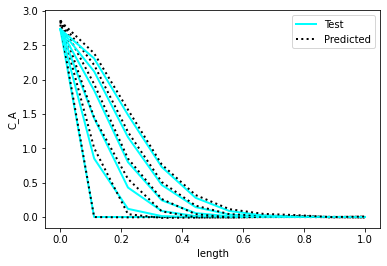

In [24]:
# Visualizing the concentration profile of the test and predicted data for entire time-length

for i in range(6):
    if i == 0:
        plt.plot(z, y_test[1, i, :10], color='cyan', lw=2, label='Test')
        plt.plot(z, y_predict_test[1, i, :10],color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(z, y_test[1, i, :10], color='cyan', lw=2)
        plt.plot(z, y_predict_test[1, i, :10], color='black', lw=2, ls=':') 

plt.ylabel("C_A")
plt.xlabel("length")
plt.legend()

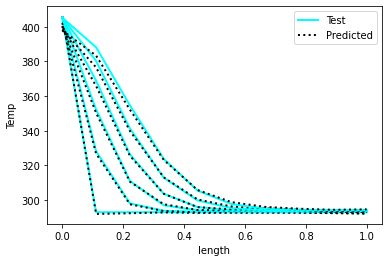

In [25]:
# Visualizing the temperature profile of the test and predicted data for entire time-length

for i in range(6):
    if i == 0:
        plt.plot(z, y_test[1, i, 10:],  color='cyan', lw=2, label='Test')
        plt.plot(z, y_predict_test[1, i, 10:], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(z, y_test[1, i, 10:],  color='cyan', lw=2)
        plt.plot(z, y_predict_test[1, i, 10:], color='black', lw=2, ls=':') 

plt.ylabel("Temp")
plt.xlabel("length")
plt.legend()

In [26]:
# Measuring the similarity between the test and predicted data fot both the concentration and temperature profile

import similaritymeasures

mseC = similaritymeasures.mse(y_test[1, i, :10], y_predict_test[1, i, :10])
print(mseC)
print(f" C profile error is {mseC}")

mseT = similaritymeasures.mse(y_test[1, :, 10:], y_predict_test[1, :, 10:])
print(mseT)
print(f" T profile error is {mseT}")

0.0029669499919898128
 C profile error is 0.0029669499919898128
3.881458023679665
 T profile error is 3.881458023679665
